# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Genes-that-display-non-canonical-epistasis:" data-toc-modified-id="Genes-that-display-non-canonical-epistasis:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Genes that display non-canonical epistasis:</a></div><div class="lev1 toc-item"><a href="#Plotting-genes-that-display-non-canonical-changes:" data-toc-modified-id="Plotting-genes-that-display-non-canonical-changes:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plotting genes that display non-canonical changes:</a></div><div class="lev2 toc-item"><a href="#Figure-7A" data-toc-modified-id="Figure-7A-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 7A</a></div><div class="lev2 toc-item"><a href="#7B" data-toc-modified-id="7B-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>7B</a></div>

In this notebook, I will identify genes that do not conform to the canonical epistasis relationships expected for the hypoxia pathway in *C. elegans*.

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# TEA and morgan
import genpy
import gvars
import morgan as morgan
import tissue_enrichment_analysis as tea

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
# rc('text', usetex=True)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 14

genvar = gvars.genvars()
q=0.1

kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth/kallisto/'

# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# add dataframes
for file in os.listdir("../sleuth/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

# tidy up
frames = []
for key, df in thomas.beta.items():
    if key != 'g':
        df['code'] = key
        df['genotype'] = genvar.fancy_mapping[key]
        frames += [df]

tidy_data = pd.concat(frames)
tidy_data.dropna(subset=['ens_gene'], inplace=True)

# Genes that display non-canonical epistasis:

To identify genes that display non-canonical epistasis, I will fuse some columns to the dataframe containing the *rhy-1* transcriptome. Using these columns, we will find genes that have inverse expression changes between *vhl-1(lf)* mutants and *egl-9(lf)* or *rhy-1(lf)* mutants. 

In [5]:
# place all 
df1 = thomas.beta['e'].copy()
df2 = thomas.beta['b']
df3 = thomas.beta['d']

df1['b_b'] = df2.b
df1['b_d'] = df3.b

df1['q_b'] = df2.qval
df1['q_d'] = df3.qval

In [6]:
# use least strict conditions:
lowestrhy = (df1.b*df1.b_d < 0)  # egl anti vhl

lowestsigrhy = ((df1.qval < q) &  # egl sig
                (df1.q_d < q))   # vhl sig
               

lowestegl = (df1.b_b*df1.b_d < 0)  # egl anti vhl


lowestsigegl = ((df1.q_b < q) &  # egl sig
                (df1.q_d < q))   # vhl sig

Now that we have coded up the conditions, let's see what we get!

In [7]:
df1.sort_values('qval', ascending=True)

hifoh = df1[
        (lowestegl & lowestsigegl) |
        (lowestrhy & lowestsigrhy)].target_id.unique()

print('{0} candidates found for HIF-1-OH regulation'.format(len(hifoh)))
df1[(lowestegl & lowestsigegl) |
    (lowestrhy & lowestsigrhy)].to_csv('../output/hifoh_candidates.csv', index=False)

56 candidates found for HIF-1-OH regulation


# Plotting genes that display non-canonical changes:

So far, all I have done is find the genes that have different expression between *vhl-1* and *egl-9*. It would be very interesting if genes that have these different behaviors still conform to the same epistatic rules (*egl-9* = *egl-9;vhl-1* and *hif-1 = egl-9 hif-1*). We can make a qPCR plot to see if that is the case:

In [8]:
tidy = tidy_data[tidy_data.target_id.isin(hifoh)].copy()

x_sort = {}
for i, xi in enumerate(tidy.target_id.unique()):
    x_sort[xi] = i + 1


tidy['order'] = tidy.target_id.map(x_sort)
tidy.sort_values('order', inplace=True)
tidy.reset_index(inplace=True)

Initially, let's just look at the first five genes in our set:

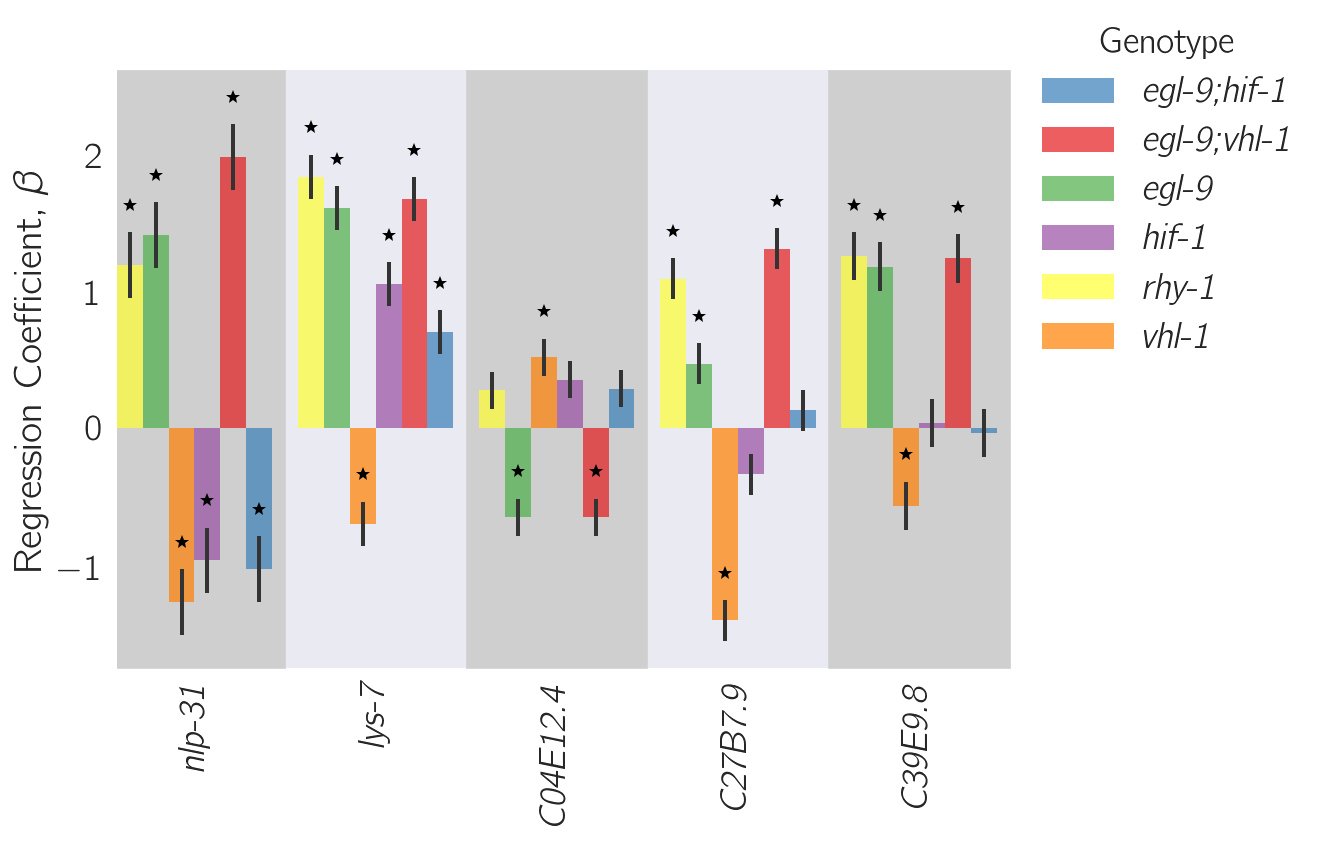

In [9]:
ind = tidy.target_id.isin(tidy.target_id.unique()[0:5])
genpy.qPCR_plot(tidy[ind], genvar.plot_order, genvar.plot_color,
                clustering='genotype', plotting_group='target_id', rotation=90)

Wow! All of them obey the epistatic rules! This is cool. Let's save this list.

In [10]:
df1[df1.target_id.isin(hifoh)].to_csv('../output/hifoh_regulation_candidates.csv', index=False)

## Figure 7A

Next, i will generate figure 7A and 7B in the paper.

In [11]:
new_order = {r'\emph{egl-9}': 0,
             r'\emph{vhl-1}': 1,
            }

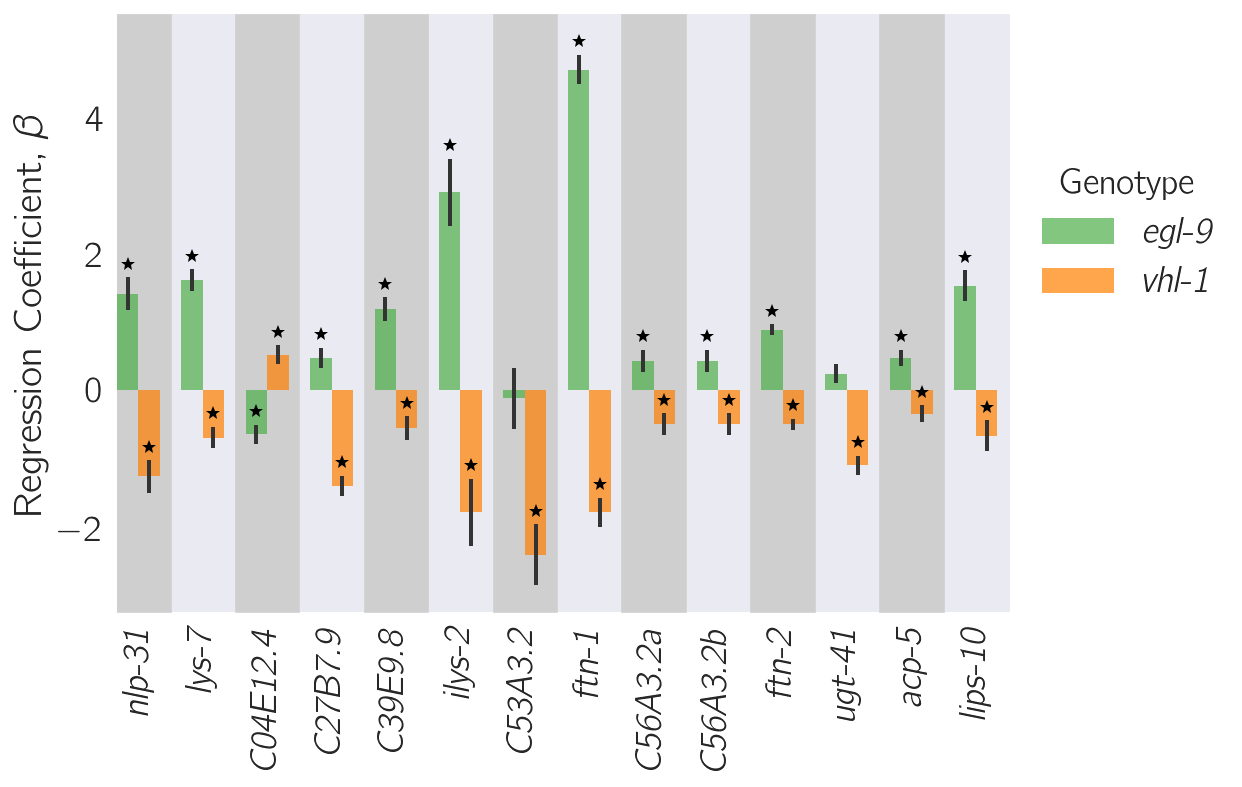

In [12]:
genpy.qPCR_plot(tidy[(tidy.target_id.isin(hifoh[0:15])) & (tidy.code.isin(['b', 'd']))],
                new_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)

plt.savefig('../output/vhl1_noncanonical.svg')

## 7B

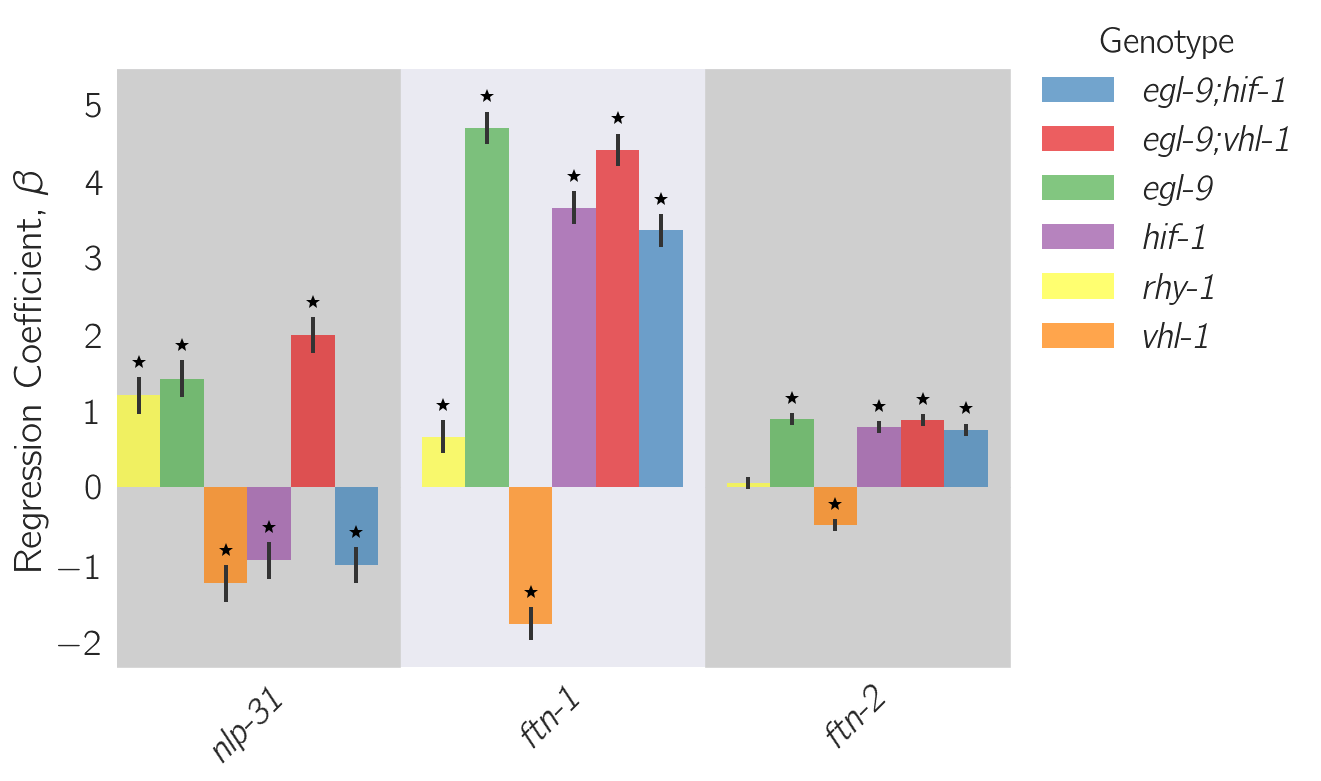

In [13]:
to_focus_on = ['nlp-31', 'ftn-1', 'ftn-2']

gene_order = {'nlp-31': 1, 'ftn-1': 2, 'ftn-2': 3}

temp = tidy[(tidy.ext_gene.isin(to_focus_on))].copy()
del temp['order']
temp['order'] = temp.ext_gene.map(gene_order)

genpy.qPCR_plot(temp,
                genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='ext_gene')
plt.savefig('../output/hif1oh_qPCR.svg', bbox_inches='tight')

In [14]:
tdf = tea.fetch_dictionary('tissue')

In [15]:
tea.enrichment_analysis(tidy.ens_gene.unique(), tdf)

Executing script

Analysis returned no enriched tissues.


,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
